In [399]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import warnings
import matplotlib.pyplot as plt

In [400]:
import sys, os

sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *
from modules.storage import get_demand_model_data, get_availability_model_data, get_demand_orig_dest_model_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [401]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Prediction Results
In this notebook we will compare the performance of our three different models, namely, Neural Network, Support Vector Machine and XGBoost.
To evaluate their performance, we use the following metrics:

| Metric | Description |
| ------ | ----------- |
| `mse`    | Mean squared error |
| `mae`    | Mean absolute error |
| `non_zero_mape` | Mean absolute percentage error of all samples where $y_{true} \neq 0$ | 
| `zero_accuracy`² | How accurate can the model predict $y_{true} = 0$ or $y_{true} \neq 0$ |
| `train_duration` | Time taken to train the model in seconds |


²For this metric we first rounded each prediction and then classified the prediction as zero or non-zero. We did the same for the outcome (without rounding as the outcome is integer) and then calculated the accuracy.


In [402]:
relevant_cols = [
	"h3_res",
	"time_interval_length",
	"model",
	"test_mse",
	"test_mae",
	"test_non_zero_mape",
	"test_zero_accuracy",
	"train_duration",
]

In [403]:
def read_all_results(outcome: str):
    svm_results = pd.read_parquet(
        SVM_SECOND_STAGE_DEMAND_RESULTS_PATH
        if outcome == "demand"
        else SVM_SECOND_STAGE_AVAILABILITY_RESULTS_PATH
    ).rename(columns={"mean_fit_time": "train_duration"})
    xgboost_results = pd.read_parquet(
        XGBOOST_SECOND_STAGE_DEMAND_RESULTS_PATH
        if outcome == "demand"
        else XGBOOST_SECOND_STAGE_AVAILABILITY_RESULTS_PATH
    )
    nn_results = pd.read_parquet(
        NN_FOURTH_STAGE_DEMAND_RESULTS_PATH
        if outcome == "demand"
        else NN_FOURTH_STAGE_AVAILABILITY_RESULTS_PATH
    )

    svm_results["model"] = "svm - " + svm_results["param_kernel"]
    nn_results["model"] = "nn"
    xgboost_results["model"] = "xgboost"
    return pd.concat(
        [
            svm_results[relevant_cols],
            nn_results[relevant_cols],
            xgboost_results[relevant_cols],
        ]
    )


In [404]:
def get_data_stats(outcome: str, h3_res: int, time_interval_length: int):
    getter = (
        (lambda _, __: get_demand_orig_dest_model_data())
        if (
            outcome == "demand"
            and h3_res
            == int(
                f"{ORIGIN_DESTINATION_H3_RESOLUTION}{ORIGIN_DESTINATION_H3_RESOLUTION}"
            )
        )
        else get_demand_model_data
        if outcome == "demand"
        else get_availability_model_data
    )
    model_data_train, model_data_test = getter(h3_res, time_interval_length)
    model_data = pd.concat([model_data_train, model_data_test])
    median = model_data.outcome.median()
    mean = model_data.outcome.mean()
    std = model_data.outcome.std()
    maximum = model_data.outcome.max()
    perc_0 = model_data.outcome[model_data.outcome == 0].count() / len(model_data)

    return pd.Series(
        {
            "median": median,
            "mean": mean,
            "std": std,
            "maximum": maximum,
            "perc_0": perc_0,
            "train_size": len(model_data_train),
            "test_size": len(model_data_test),
            "dataset_size": len(model_data),
            "svm_train_size": max(30_000, len(model_data_train)),
        }
    )


In [405]:
base_stats_table = pd.DataFrame(
    [
        pd.Series({"h3_res": h3_res, "time_interval_length": time_interval_length})
        for h3_res in PREDICTIVE_H3_RESOLUTIONS
        for time_interval_length in CALC_TIME_INTERVAL_LENGTHS
    ] + [
        pd.Series({"h3_res": h3_res, "time_interval_length": time_interval_length})
        for h3_res, time_interval_length in ADDITIONAL_PREDICTIVE_RESOLUTIONS
    ]
)

In [406]:
def visualize_metric(results: pd.DataFrame, metric: str, remove_n_worst: int = 0):
	pivoted_results = results.pivot(index=["h3_res", "time_interval_length"], columns='model', values=metric)
	if remove_n_worst > 0:
		pivoted_results['max'] = pivoted_results.max(axis=1)
		pivoted_results = pivoted_results.nsmallest(len(pivoted_results) - remove_n_worst, "max")
		pivoted_results = pivoted_results.drop('max', axis=1)
		pivoted_results = pivoted_results.sort_index()
	ax = pivoted_results.plot(kind="barh", figsize=(8, 8))
	ax.set_xlabel(metric)
	plt.show()
	return pivoted_results

In [407]:
def visualize_agg_metric(results: pd.DataFrame, metric: str, best="min"):
	pivoted = results.pivot(
		index=["h3_res", "time_interval_length"], columns="model", values=metric
	)
	if best == "min":
		pivoted = pivoted.min(axis=1)
	else:
		pivoted = pivoted.max(axis=1)
	ax = pivoted.plot(kind="barh", figsize=(8, 8))
	ax.set_xlabel(metric)
	plt.show()
	return pivoted.to_frame(metric)

In [408]:
metrics = [
    "test_mse",
    "test_mae",
    "test_non_zero_mape",
    "test_zero_accuracy",
    "train_duration",
]


In [409]:
def benchmark_all_resolutions(results: pd.DataFrame):
	metric_winners = {}
	for metric in metrics:
		pivot = results.pivot(
				index=["h3_res", "time_interval_length"], columns="model", values=metric
		)
		if metric == "test_zero_accuracy":
			pivot['best_model'] = pivot.idxmax(axis=1)
		else:
			pivot['best_model'] = pivot.idxmin(axis=1)
		metric_winners[metric] = pivot.best_model.value_counts()
	metric_winners = pd.DataFrame(metric_winners).fillna(0).astype(int)
	metric_winners['overall'] = metric_winners.sum(axis=1)
	return metric_winners.transpose()

### Demand Results
First we will look at the demand results.

In [410]:
demand_results = read_all_results("demand")

In [411]:
demand_results.head()

,h3_res,time_interval_length,model,test_mse,test_mae,test_non_zero_mape,test_zero_accuracy,train_duration
0,7,1,svm - poly,2.665077,0.511289,0.448406,0.898903,59.233981
1,7,2,svm - poly,19.301339,1.431508,0.366964,0.811201,106.339026
2,7,6,svm - poly,90.023110,3.000653,0.220547,0.783393,174.270175
3,7,24,svm - poly,384.364754,6.656288,0.167891,0.790748,11.472640
4,8,1,svm - poly,0.512375,0.275154,0.622341,0.915995,137.719914


In addition to the results we will also create some statistics about the demand datasets, like the mean, median, standard deviation, etc.
These statistics can be helpful when evaluating certain metrics.

In [412]:
demand_stats_table = pd.concat(
    [
        base_stats_table,
        pd.DataFrame(
            [
                {
                    "h3_res": int(
                        f"{ORIGIN_DESTINATION_H3_RESOLUTION}{ORIGIN_DESTINATION_H3_RESOLUTION}"
                    ),
                    "time_interval_length": ORIGIN_DESTINATION_TIME_INTERVAL_LENGTH,
                }
            ]
        ),
    ],
)

In [413]:
demand_stats_table = pd.concat(
	[
		demand_stats_table,
		demand_stats_table.apply(
			lambda row: get_data_stats("demand", row.h3_res, row.time_interval_length),
			axis=1,
		),
	],
	axis=1,
)

In [414]:
demand_stats_table

,h3_res,time_interval_length,median,mean,std,maximum,perc_0,train_size,test_size,dataset_size,svm_train_size
0,7,1,0.0,0.676690,3.510246,100.0,0.906053,211114.0,211115.0,422229.0,211114.0
1,7,2,0.0,2.744735,12.121042,372.0,0.846248,103475.0,103475.0,206950.0,103475.0
2,7,6,0.0,11.276330,40.433588,703.0,0.757468,35164.0,35165.0,70329.0,35164.0
3,7,24,0.0,37.177494,105.456392,1011.0,0.574879,8797.0,8798.0,17595.0,30000.0
4,8,1,0.0,0.161691,0.941036,43.0,0.939523,881713.0,881714.0,1763427.0,881713.0
5,8,2,0.0,0.628188,3.062797,163.0,0.893093,451151.0,451151.0,902302.0,451151.0
6,8,6,0.0,2.561613,9.744621,259.0,0.806417,154448.0,154448.0,308896.0,154448.0
7,8,24,0.0,8.410319,24.519968,344.0,0.651968,38812.0,38813.0,77625.0,38812.0
8,9,24,0.0,2.653434,6.890685,113.0,0.652465,118680.0,118680.0,237360.0,118680.0
0,77,24,0.0,0.628622,6.057796,343.0,0.948246,457470.0,457470.0,914940.0,457470.0


We will now evaluate the models with one metric at a time over all possible resolutions.

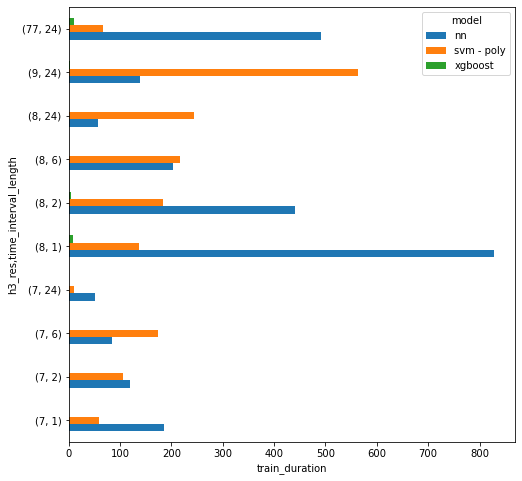

model                                nn  svm - poly    xgboost
h3_res time_interval_length                                   
7      1                     186.338808   59.233981   1.257670
       2                     118.628595  106.339026   0.587917
       6                      84.846213  174.270175   0.326107
       24                     51.822149   11.472640   0.148273
8      1                     827.665968  137.719914   8.869535
       2                     439.822626  183.379655   4.662645
       6                     203.167135  216.618685   1.666206
       24                     58.101990  244.099163   0.629647
9      24                    139.595377  562.608911   2.972068
77     24                    492.197467   66.164266  11.415257

In [415]:
visualize_metric(demand_results, "train_duration")

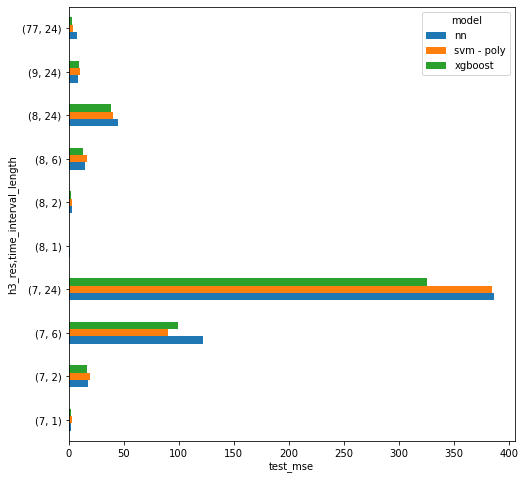

model                                nn  svm - poly     xgboost
h3_res time_interval_length                                    
7      1                       2.112337    2.665077    2.107795
       2                      17.645970   19.301339   16.923856
       6                     121.578570   90.023110   99.559855
       24                    385.978276  384.364754  325.165615
8      1                       0.907417    0.512375    0.316263
       2                       2.682283    3.374197    2.331867
       6                      14.918592   16.535265   12.722411
       24                     44.829146   40.259285   38.277176
9      24                      8.768210   10.447953    9.846083
77     24                      7.997945    4.138852    2.873258

In [416]:
visualize_metric(demand_results, "test_mse")

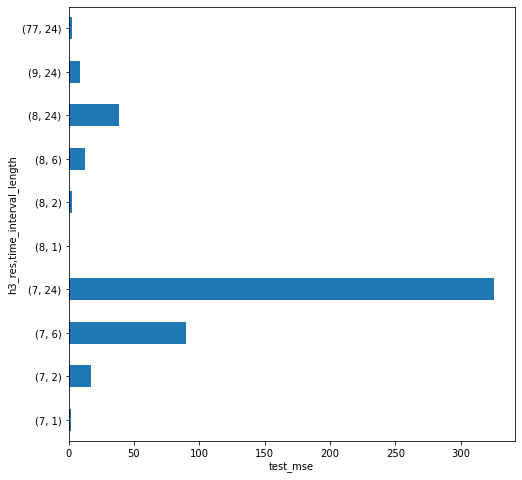

test_mse
h3_res time_interval_length            
7      1                       2.107795
       2                      16.923856
       6                      90.023110
       24                    325.165615
8      1                       0.316263
       2                       2.331867
       6                      12.722411
       24                     38.277176
9      24                      8.768210
77     24                      2.873258

In [417]:
visualize_agg_metric(demand_results, "test_mse", best="min")

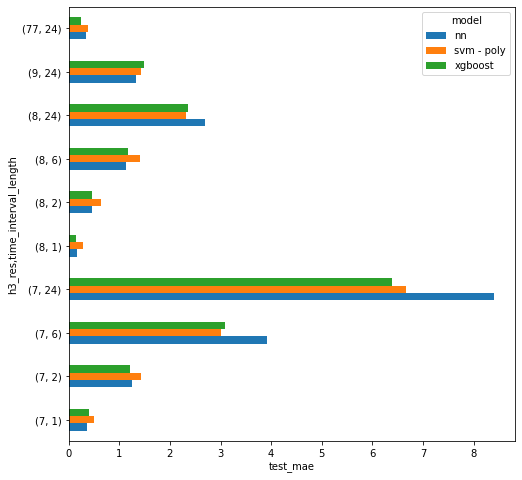

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     0.354515    0.511289  0.401879
       2                     1.260489    1.431508  1.211695
       6                     3.922868    3.000653  3.081985
       24                    8.396101    6.656288  6.377749
8      1                     0.161567    0.275154  0.155813
       2                     0.471627    0.646611  0.459649
       6                     1.138881    1.400172  1.179981
       24                    2.685330    2.317048  2.361297
9      24                    1.323776    1.427058  1.481476
77     24                    0.346599    0.380661  0.252244

In [418]:
visualize_metric(demand_results, "test_mae")

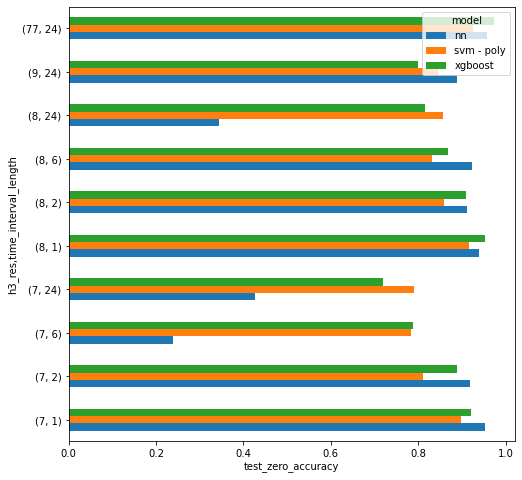

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     0.952907    0.898903  0.920896
       2                     0.917816    0.811201  0.889490
       6                     0.239784    0.783393  0.787800
       24                    0.426461    0.790748  0.719595
8      1                     0.939471    0.915995  0.953848
       2                     0.911342    0.859193  0.909112
       6                     0.922531    0.832144  0.868111
       24                    0.344550    0.857496  0.814572
9      24                    0.888043    0.846259  0.798559
77     24                    0.958253    0.925897  0.973002

In [419]:
visualize_metric(demand_results, "test_zero_accuracy")

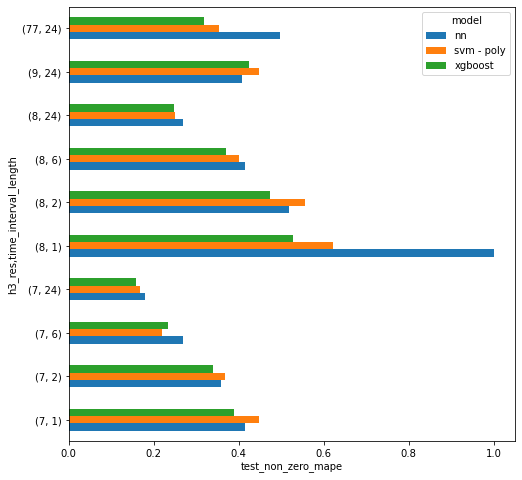

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     0.415404    0.448406  0.389319
       2                     0.358513    0.366964  0.339852
       6                     0.269336    0.220547  0.234628
       24                    0.180705    0.167891  0.159449
8      1                     1.000000    0.622341  0.528939
       2                     0.519434    0.556452  0.473163
       6                     0.415263    0.400860  0.371230
       24                    0.267945    0.250466  0.248011
9      24                    0.407589    0.448487  0.424325
77     24                    0.496868    0.353108  0.318325

In [420]:
visualize_metric(demand_results, "test_non_zero_mape")
# nn non_zero_mape is 1.0 because it always predicts 0

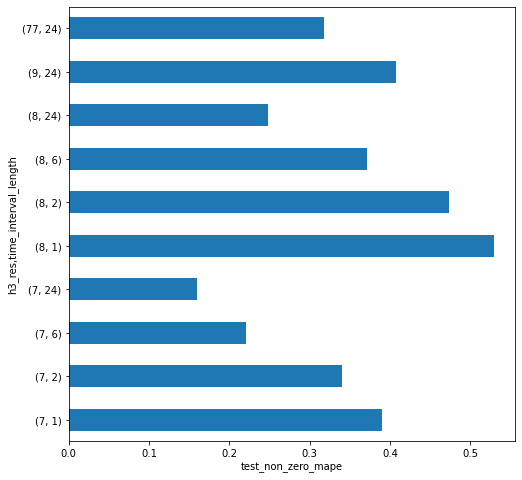

test_non_zero_mape
h3_res time_interval_length                    
7      1                               0.389319
       2                               0.339852
       6                               0.220547
       24                              0.159449
8      1                               0.528939
       2                               0.473163
       6                               0.371230
       24                              0.248011
9      24                              0.407589
77     24                              0.318325

In [421]:
visualize_agg_metric(demand_results, "test_non_zero_mape", best="min")

Last, we will also create a benchmark for the models, by aggregating their performance over all possible resolutions and metrics.  
To do that we compare their performance in one specific metric and resolution. The best model receives a point for that metric. We then repeat for all possible resolutions and metrics.  
The results then show how often a model is the best one in one specific metric.

,nn,svm - poly,xgboost
test_mse,1,1,8
test_mae,3,2,5
test_non_zero_mape,1,1,8
test_zero_accuracy,5,2,3
train_duration,0,0,10
overall,10,6,34


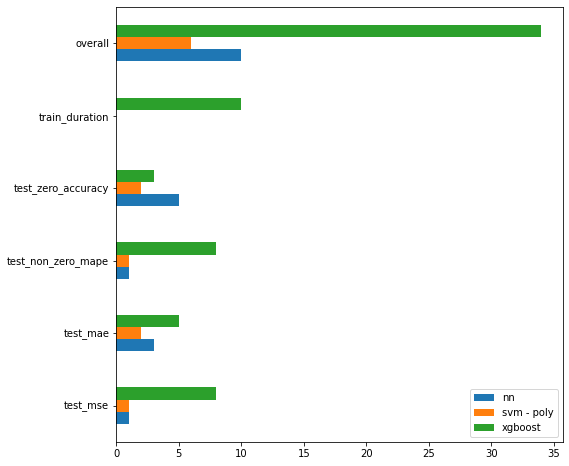

In [422]:
demand_benchmark = benchmark_all_resolutions(demand_results)
demand_benchmark.plot(kind="barh", figsize=(8, 8))
demand_benchmark

### Availability Results
We will now repeat the exact same procedure for availability.

In [423]:
availability_stats_table = pd.concat(
	[
		base_stats_table,
		base_stats_table.apply(
			lambda row: get_data_stats("availability", row.h3_res, row.time_interval_length),
			axis=1,
		),
	],
	axis=1,
)

availability_stats_table

,h3_res,time_interval_length,median,mean,std,maximum,perc_0,train_size,test_size,dataset_size,svm_train_size
0,7,1,0.0,5.755109,13.763612,190.0,0.624848,235899.0,235899.0,471798.0,235899.0
1,7,2,0.0,5.934785,14.219029,183.0,0.623708,117963.0,117963.0,235926.0,117963.0
2,7,6,0.0,6.711749,16.032654,174.0,0.619004,39339.0,39339.0,78678.0,39339.0
3,7,24,0.0,10.485084,22.668667,174.0,0.597615,9855.0,9855.0,19710.0,30000.0
4,8,1,0.0,1.327515,3.423869,70.0,0.719383,1017860.0,1017861.0,2035721.0,1017860.0
5,8,2,0.0,1.369063,3.520954,70.0,0.717059,508988.0,508989.0,1017977.0,508988.0
6,8,6,0.0,1.548785,3.911882,64.0,0.707291,169740.0,169741.0,339481.0,169740.0
7,8,24,0.0,2.421447,5.357067,54.0,0.663272,42522.0,42523.0,85045.0,42522.0
8,9,24,0.0,0.727274,1.682266,30.0,0.726547,131947.0,131948.0,263895.0,131947.0


In [424]:
availability_results = read_all_results("availability")

In [425]:
availability_results.head(5)

,h3_res,time_interval_length,model,test_mse,test_mae,test_non_zero_mape,test_zero_accuracy,train_duration
0,7,1,svm - poly,37.127169,2.948520,0.386876,0.557705,353.543360
1,7,2,svm - poly,35.567582,2.545455,0.355072,0.733247,1775.216243
2,7,6,svm - poly,35.610647,2.313836,0.307780,0.889143,2130.720859
3,7,24,svm - poly,55.988396,3.165796,0.256407,0.768442,28.980687
4,8,1,svm - poly,4.681280,1.029570,0.527839,0.809220,264.819012


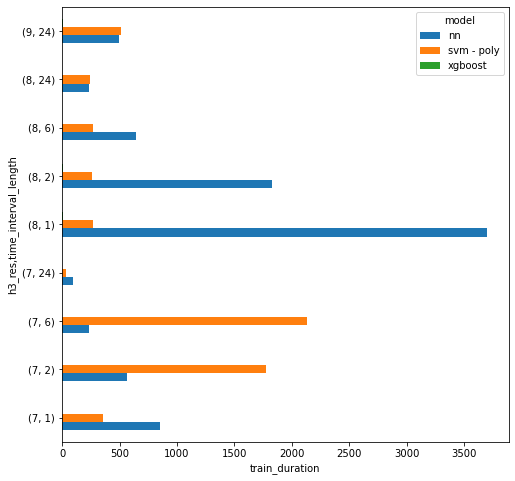

model                                 nn   svm - poly   xgboost
h3_res time_interval_length                                    
7      1                      855.901519   353.543360  1.249498
       2                      560.716685  1775.216243  0.642328
       6                      236.145673  2130.720859  0.294997
       24                      94.846507    28.980687  0.142630
8      1                     3703.945640   264.819012  8.780498
       2                     1830.123308   263.425706  4.859004
       6                      641.114363   267.706322  1.603323
       24                     230.024005   243.093547  0.600216
9      24                     498.783041   514.563769  2.966701

In [426]:
visualize_metric(availability_results, "train_duration")

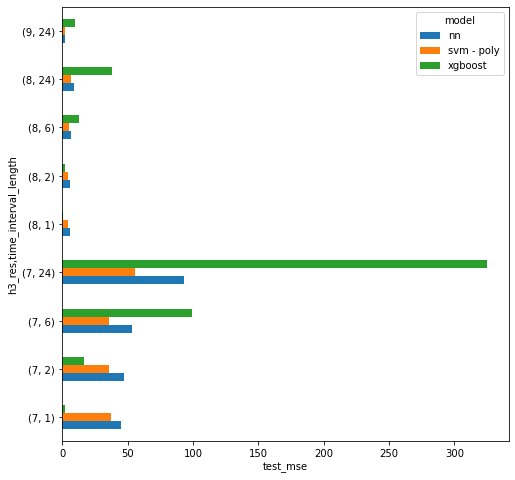

model                               nn  svm - poly     xgboost
h3_res time_interval_length                                   
7      1                     45.103438   37.127169    2.107795
       2                     47.166135   35.567582   16.923856
       6                     53.590551   35.610647   99.559855
       24                    93.348040   55.988396  325.165615
8      1                      5.674175    4.681280    0.316263
       2                      5.697243    4.545798    2.331867
       6                      6.773018    4.928011   12.722411
       24                     9.372776    6.854364   38.277176
9      24                     1.812260    1.914686    9.846083

In [427]:
visualize_metric(availability_results, "test_mse")

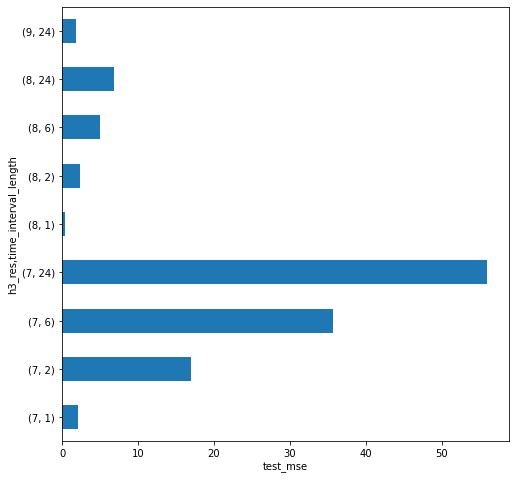

test_mse
h3_res time_interval_length           
7      1                      2.107795
       2                     16.923856
       6                     35.610647
       24                    55.988396
8      1                      0.316263
       2                      2.331867
       6                      4.928011
       24                     6.854364
9      24                     1.812260

In [428]:
visualize_agg_metric(availability_results, "test_mse", best="min")

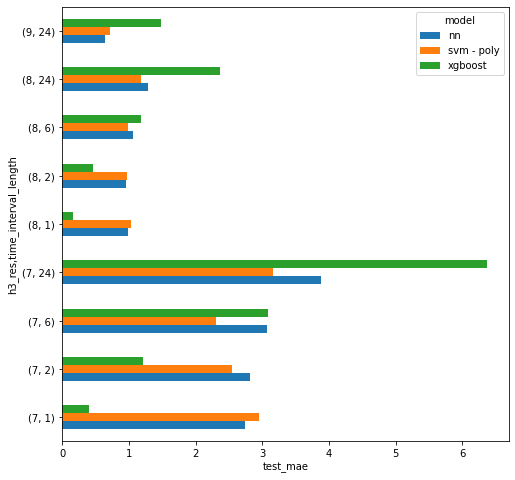

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     2.734877    2.948520  0.401879
       2                     2.816211    2.545455  1.211695
       6                     3.066465    2.313836  3.081985
       24                    3.883434    3.165796  6.377749
8      1                     0.983003    1.029570  0.155813
       2                     0.961181    0.978162  0.459649
       6                     1.063654    0.989950  1.179981
       24                    1.280754    1.181139  2.361297
9      24                    0.646167    0.712426  1.481476

In [429]:
visualize_metric(availability_results, "test_mae")

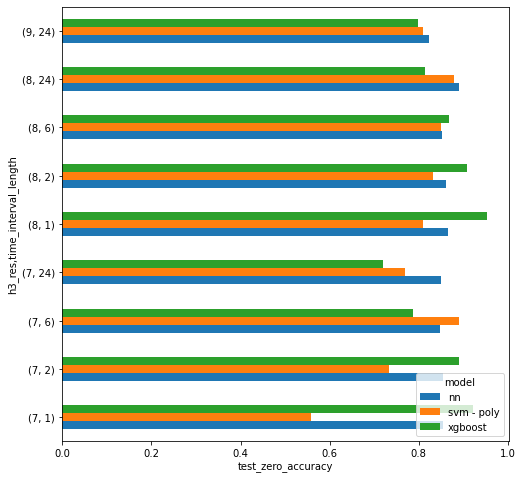

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     0.855141    0.557705  0.920896
       2                     0.853768    0.733247  0.889490
       6                     0.846844    0.889143  0.787800
       24                    0.849619    0.768442  0.719595
8      1                     0.865919    0.809220  0.953848
       2                     0.862052    0.832024  0.909112
       6                     0.853029    0.850278  0.868111
       24                    0.889425    0.878042  0.814572
9      24                    0.822044    0.809592  0.798559

In [430]:
visualize_metric(availability_results, "test_zero_accuracy")

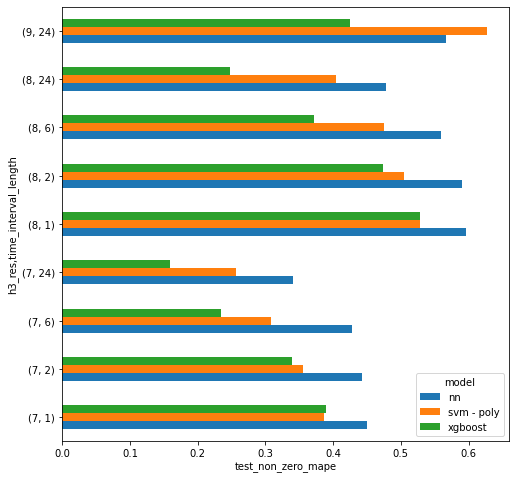

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     0.450544    0.386876  0.389319
       2                     0.442670    0.355072  0.339852
       6                     0.427757    0.307780  0.234628
       24                    0.341454    0.256407  0.159449
8      1                     0.596280    0.527839  0.528939
       2                     0.589726    0.504630  0.473163
       6                     0.559425    0.475697  0.371230
       24                    0.477692    0.404322  0.248011
9      24                    0.566795    0.627857  0.424325

In [431]:
visualize_metric(availability_results, "test_non_zero_mape")

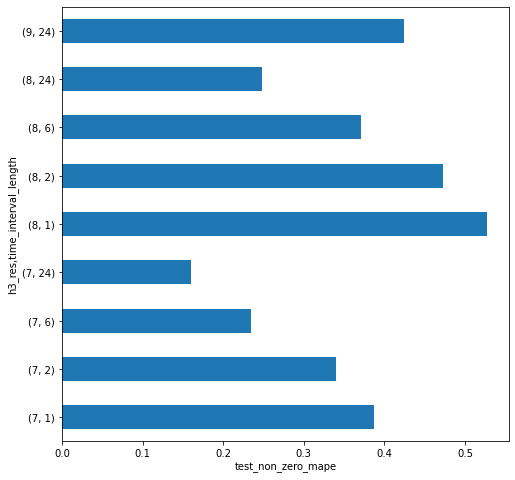

test_non_zero_mape
h3_res time_interval_length                    
7      1                               0.386876
       2                               0.339852
       6                               0.234628
       24                              0.159449
8      1                               0.527839
       2                               0.473163
       6                               0.371230
       24                              0.248011
9      24                              0.424325

In [432]:
visualize_agg_metric(availability_results, "test_non_zero_mape", best="min")

,nn,svm - poly,xgboost
test_mse,1,4,4
test_mae,1,4,4
test_non_zero_mape,0,2,7
test_zero_accuracy,3,1,5
train_duration,0,0,9
overall,5,11,29


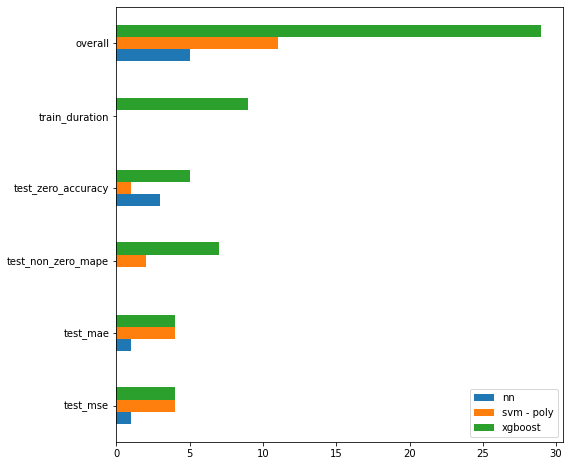

In [433]:
availability_benchmark = benchmark_all_resolutions(availability_results)
availability_benchmark.plot(kind="barh", figsize=(8, 8))
availability_benchmark